In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import random

In [2]:
merge_data_type = True # Flag used to determine if data types will be loaded independently or jointly
if merge_data_type:
    procedure = ['Healthy', 'COLPOs','LEEPs']
    results_folders=[]

    for folder_name in procedure:
        main_path = 'R:\\Cervical_Project\\Data\\' + folder_name
        os.chdir(main_path)
        files = os.listdir()
        for file in files:
            new_path = os.path.join(main_path, file)
            print(new_path)
            if os.path.isdir(new_path) and 'results_final' in os.listdir(new_path):
                paired_path = os.path.join(new_path, 'results_final')
                results_folders.append(paired_path)
else:
    # Uncomment what data type you want to work with    
    main_path= "R:\Cervical_Project\Data\Healthy"
    # main_path= "R:\Cervical_Project\Data\COLPOs"
    # main_path= "R:\Cervical_Project\Data\Leeps"
    os.chdir(main_path)
    files = os.listdir()
    results_folders=[]
    files = os.listdir()
    for file in files:
        new_path = os.path.join(main_path, file)
        print(new_path)
        if os.path.isdir(new_path) and 'results_final' in os.listdir(new_path):
            paired_path = os.path.join(new_path, 'results_final')
            results_folders.append(paired_path)

R:\Cervical_Project\Data\Healthy\20191003_Hysterectomy
R:\Cervical_Project\Data\Healthy\20191031_Hysterectomy
R:\Cervical_Project\Data\Healthy\20191107_Hysterectomy
R:\Cervical_Project\Data\Healthy\20191121_Hysterectomy
R:\Cervical_Project\Data\Healthy\20200220_Hysterectomy
R:\Cervical_Project\Data\Healthy\20200305_Hysterectomy
R:\Cervical_Project\Data\Healthy\20200928_Hysterectomy
R:\Cervical_Project\Data\Healthy\20201008_Hysterectomy
R:\Cervical_Project\Data\Healthy\20201119_Hysterectomy
R:\Cervical_Project\Data\Healthy\20201127_Hysterectomy
R:\Cervical_Project\Data\Healthy\20201214_Hysterectomy
R:\Cervical_Project\Data\Healthy\20210218_Hysterectomy
R:\Cervical_Project\Data\Healthy\20210415_Hysterectomy
R:\Cervical_Project\Data\Healthy\20210423_Hysterectomy
R:\Cervical_Project\Data\Healthy\20210526_Hysterectomy
R:\Cervical_Project\Data\Healthy\20210715_Hysterectomy
R:\Cervical_Project\Data\Healthy\20211104_Hysterectomy
R:\Cervical_Project\Data\Healthy\20220331_Hysterectomy
R:\Cervica

In [3]:
results_folders

['R:\\Cervical_Project\\Data\\Healthy\\20191003_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20191031_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20191107_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20191121_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20200220_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20200305_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20200928_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20201008_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20201119_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20201127_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20201214_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20210218_Hysterectomy\\results_final',
 'R:\\Cervical_Project\\Data\\Healthy\\20210415_Hysterectomy\\re

In [4]:
def normalize(image, p_min=2, p_max=99.9, dtype='float32'):
    '''
    Normalizes the image intensity so that the `p_min`-th and the `p_max`-th
    percentiles are converted to 0 and 1 respectively.
    References
    ----------
    Content-Aware Image Restoration: Pushing the Limits of Fluorescence
    Microscopy
    https://doi.org/10.1038/s41592-018-0216-7
    '''
    low, high = np.percentile(image, (p_min, p_max))
    return (image - low) / (high - low + 1e-6)

def patch_image(image):
    '''Image should be 512x512'''
    return image.reshape(2, 256, 2, 256).swapaxes(1, 2).reshape(4, 256, 256)

def stitch_image(image):
    '''Image should be 4x256x256'''
    return np.reshape(image,[2, -1, 256, 256]).swapaxes(1,2).reshape(512, 512)

def create_patches(input,start,end):
    start = int(start)
    end = int(end)
    indices = list(range(start,end+1))
    total_patches = []
    for i in indices:
        image = input[i]
        image = np.transpose(image)
        image = normalize(image,2,99.9)
        patches = patch_image(image)
        total_patches.append(patches)
    total_patches = np.reshape(total_patches,(-1,256,256))
    return list(total_patches)

def noiseGen(input,start,end,lp):
    start = int(start)
    end = int(end)
    indices = list(range(start,end+1))
    total_patches = []
    for i in indices:
        image = input[i]
        image = np.transpose(image)
        image = image / np.max(image)
        image = np.random.poisson(image / lp , size=np.shape(image))
        patches = patch_image(image / np.max(image))
        total_patches.append(patches)
    total_patches = np.reshape(total_patches,(-1,256,256))
    return list(total_patches)

def Patchify(f,roi_name):
    try: 
        start_stack = f['stack_begin'][0]-1
        end_stack = f['stack_end'][0]-1
        FAD= f['FAD_frames_512_shifted']
        NADH= f['NADH_frames_512_shifted']
        stack_num = end_stack - start_stack + 1
        assert stack_num > 0
        low_SNR_NADH = create_patches(NADH[1],start_stack,end_stack)
        high_SNR_NADH = create_patches(np.mean(NADH, axis=0),start_stack,end_stack)
        low_SNR_FAD = create_patches(FAD[1],start_stack,end_stack)
        high_SNR_FAD = create_patches(np.mean(FAD, axis=0),start_stack,end_stack)
        print('Start and end found: ' + roi_name + ": images=" + str(stack_num))
        return low_SNR_NADH , high_SNR_NADH, low_SNR_FAD, high_SNR_FAD, stack_num
    except:
        print('Data was not processed: ' + roi_name)
        return [],[],[],[],[]

def Patchify_Noise(f,roi_name):
    try: 
        start_stack = f['stack_begin'][0]-1
        end_stack = f['stack_end'][0]-1
        FAD= f['FAD_frames_512_shifted']
        NADH= f['NADH_frames_512_shifted']
        stack_num = end_stack - start_stack + 1
        assert stack_num > 0
        GT_NADH = np.mean(NADH, axis=0)
        GT_FAD = np.mean(FAD, axis=0)
        lp = 0.075
        low_SNR_NADH = noiseGen(GT_NADH,start_stack,end_stack,lp)
        low_SNR_FAD = noiseGen(GT_FAD,start_stack,end_stack,lp)
        high_SNR_NADH = create_patches(GT_NADH,start_stack,end_stack)
        high_SNR_FAD = create_patches(GT_FAD,start_stack,end_stack)
        print('Start and end found: ' + roi_name + ": images=" + str(stack_num))
        return low_SNR_NADH , high_SNR_NADH, low_SNR_FAD, high_SNR_FAD, stack_num
    except:
        print('Data was not processed: ' + roi_name)
        return [],[],[],[],[]

In [5]:
size=512
X_N = []
X_F = []
Y_N = []
Y_F = []
start_list = []
end_list = []
key_names = []
ROI_counter = 0
stack_count = 0
for result_folder in results_folders:
    roi_mats = []
    os.chdir(result_folder)
    experiment_files = os.listdir()
    for experiment_file in experiment_files:
        if experiment_file.endswith('FINAL.mat'):
            roi_mats.append(experiment_file)
    for roi in roi_mats:
        roi_name = roi[0:-4]
        f= h5py.File(roi)
        low_SNR_NADH , high_SNR_NADH, low_SNR_FAD, high_SNR_FAD, stack_num = Patchify_Noise(f,roi_name)
        if len(low_SNR_NADH) > 0:
            key_names.append(roi_name)
            X_N.append(low_SNR_NADH)
            Y_N.append(high_SNR_NADH)
            X_F.append(low_SNR_FAD)
            Y_F.append(high_SNR_FAD)
            ROI_counter += 1
            start_list.append(int(stack_count*4))
            stack_count += stack_num 
            end_list.append(int(stack_count*4-1))
print('done')

Data was not processed: 20191003_Hysterectomy_ROI1_Series019_Series020_FINAL
Data was not processed: 20191003_Hysterectomy_ROI2_Series030_Series033_FINAL
Data was not processed: 20191003_Hysterectomy_ROI3_Series036_Series035_FINAL
Data was not processed: 20191031_Hysterectomy_ROI1_Series005_Series006_FINAL
Data was not processed: 20191031_Hysterectomy_ROI2_Series008_Series009_FINAL
Data was not processed: 20191031_Hysterectomy_ROI3_Series011_Series012_FINAL
Data was not processed: 20191031_Hysterectomy_ROI4_Series014_Series015_FINAL
Data was not processed: 20191031_Hysterectomy_ROI5_Series017_Series019_FINAL
Start and end found: 20191107_Hysterectomy_ROI1_FLIM 008_FLIM 2_016_FLIM 014_FLIM 2_022_FINAL: images=[40.]
Start and end found: 20191121_Hysterectomy_ROI1_Series004_Series005_FINAL: images=[25.]
Start and end found: 20191121_Hysterectomy_ROI2_Series012_Series014_FINAL: images=[33.]
Start and end found: 20191121_Hysterectomy_ROI3_Series021_Series022_FINAL: images=[29.]
Start and en

In [9]:
if merge_data_type:
    ROIs = ROI_counter
    testing_split = round(ROIs*1/3)
    random.seed(0)
    
    Training_idx = sorted(random.sample(range(0,ROIs), ROIs-testing_split))
    Training_idx = [int(x) for x in Training_idx] 
    Testing_idx = sorted([x for x in list(range(0,ROIs)) if x not in Training_idx])

    key_names = np.array(key_names)
    start_list = np.array(start_list)
    end_list = np.array(end_list)
    X_N, X_F, Y_N, Y_F = np.array(X_N, dtype=object), np.array(X_F, dtype=object), np.array(Y_N, dtype=object), np.array(Y_F,dtype=object)

    key_names_train = key_names[Training_idx]
    start_list_train = start_list[Training_idx]
    end_list_train = end_list[Training_idx]
    X_N_train = X_N[Training_idx]
    Y_N_train = Y_N[Training_idx]
    X_F_train = X_F[Training_idx]
    Y_F_train = Y_F[Training_idx]

    key_names_test = key_names[Testing_idx]
    start_list_test = start_list[Testing_idx]
    end_list_test = end_list[Testing_idx]
    X_N_test = X_N[Testing_idx]
    Y_N_test= Y_N[Testing_idx]
    X_F_test = X_F[Testing_idx]
    Y_F_test = Y_F[Testing_idx]

    # Training Set Saving
    ROI_keys = [key[:(key.find('ROI')+4)] for key in key_names_train]
    stack_begin = [item for item in start_list_train]
    stack_end = [item for item in end_list_train]
    X_n = [item for sublist in X_N_train for item in sublist]
    Y_n = [item for sublist in Y_N_train for item in sublist]
    X_f = [item for sublist in X_F_train for item in sublist]
    Y_f = [item for sublist in Y_F_train for item in sublist]

    np.savez('R:\\Cervical_Project\\Data\\NV_0210_NADH_Training', X=X_n, Y=Y_n, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)
    np.savez('R:\\Cervical_Project\\Data\\NV_0210_FAD_Training', X=X_f, Y=Y_f, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)

    # Testing Set Saving
    ROI_keys = [key[:(key.find('ROI')+4)] for key in key_names_test]
    stack_begin = [item for item in start_list_test]
    stack_end = [item for item in end_list_test]
    X_n = [item for sublist in X_N_test for item in sublist]
    Y_n = [item for sublist in Y_N_test for item in sublist]
    X_f = [item for sublist in X_F_test for item in sublist]
    Y_f = [item for sublist in Y_F_test for item in sublist]

    np.savez('R:\\Cervical_Project\\Data\\NV_0210_NADH_Testing', X=X_n, Y=Y_n, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)
    np.savez('R:\\Cervical_Project\\Data\\NV_0210_FAD_Testing', X=X_f, Y=Y_f, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)
else:
    ROI_keys = [key[:(key.find('ROI')+4)] for key in key_names]
    stack_begin = [item for item in start_list]
    stack_end = [item for item in end_list]

    X_n = [item for sublist in X_N for item in sublist]
    Y_n = [item for sublist in Y_N for item in sublist]
    X_f = [item for sublist in X_F for item in sublist]
    Y_f = [item for sublist in Y_F for item in sublist]

    dtype = main_path[main_path.rfind('\\')+1:]
    nadh_fname = 'R:\\Cervical_Project\\Data\\NV_1213_NADH_' + dtype
    fad_fname = 'R:\\Cervical_Project\\Data\\NV_1213_FAD_' + dtype
    np.savez(nadh_fname, X=X_n, Y=Y_n, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)
    np.savez(fad_fname, X=X_f, Y=Y_f, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)

In [61]:
size=512
X_N = []
X_F = []
Y_N = []
Y_F = []
start_list = []
end_list = []
key_names = []
ROI_counter = 0
stack_count = 0
result_folder = results_folders[20]
roi_mats = []
os.chdir(result_folder)
experiment_files = os.listdir()
experiment_file = experiment_files[0]
if experiment_file.endswith('FINAL.mat'):
    roi_mats.append(experiment_file)
roi = roi_mats[0]
roi_name = roi[0:-4]
f= h5py.File(roi)
start_stack = f['stack_begin'][0]-1
end_stack = f['stack_end'][0]-1
FAD= f['FAD_frames_512_shifted']
NADH= f['NADH_frames_512_shifted']
stack_num = end_stack - start_stack + 1
assert stack_num > 0
GT_NADH = np.mean(NADH, axis=0)
GT_FAD = np.mean(FAD, axis=0)
scale = 1e-3


print('done')

done


In [90]:
scale = 0.05
start = int(start_stack)
end = int(end_stack)
indices = list(range(start,end+1))
total_patches = []

n_scales = 1
min_MSE = np.inf
store = np.zeros([n_scales,2])
for j in range(n_scales):
    print('Running lambda value ' + str(j+1) + ' of 50')
    mse_store = np.zeros([5,1])
    for k in range(1):
        print('\tRunning poisson iteration # ' + str(k+1) + ' of 5')
        temp_MSE_slice = np.zeros([len(indices),1])
        for idx,i in enumerate(indices):
            image = GT_NADH[i]
            image = np.transpose(image)
            image = image/np.max(image)
            image = np.random.poisson(image / scale , size=np.shape(image))
            histogram, bin_edges = np.histogram(image/np.max(image), bins=256, range=(0, 1))
            histogram2, bin_edges2 = np.histogram(np.transpose(NADH[3][i])/np.max(np.transpose(NADH[3][i])), bins=256, range=(0, 1))
            temp_MSE_slice[idx] = np.square(np.subtract(histogram2,histogram)).mean()
        temp_MSE = np.mean(temp_MSE_slice)
        mse_store[k] = temp_MSE
    temp_MSE = np.mean(mse_store)
    store[j,:] = [scale,temp_MSE]
    if temp_MSE <= min_MSE:
        scale = scale * 2
    elif temp_MSE > min_MSE:
        rescaled = scale/2 + scale/4
        scale = rescaled/2
    min_MSE = min(min_MSE,temp_MSE)

Running lambda value 1 of 50
	Running poisson iteration # 1 of 5


15321763.46388889


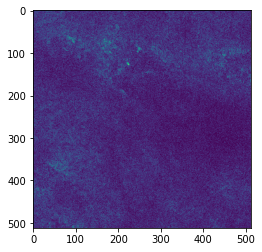

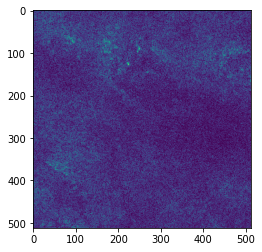

In [91]:
print(min_MSE)
plt.figure()
plt.imshow(image/np.max(image))
plt.figure()
plt.imshow(np.transpose(NADH[3][i])/np.max(np.transpose(NADH[3][i])))